In [272]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [ ]:
def torch_tensor_sizeOnDisk(tensor):
    # in MB
    return (tensor.element_size() * tensor.nelement()) / 1000000

In [4]:
def load_data(dir_load, fileName_load, path_load=None):
    from pathlib import Path
    import scipy.io
    if path_load is None:
        dir_load = Path(dir_load).resolve()
        fileName_load = fileName_load
        path_load = dir_load / fileName_load

    dat = scipy.io.loadmat(path_load)
    return dat

In [5]:
from pathlib import Path

dir_load = Path(r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/t5.2019.05.08').resolve()
fileName_load = r'sentences.mat'

sent = load_data(dir_load=dir_load,
                fileName_load=fileName_load)

In [7]:
sent.keys()

dict_keys(['__header__', '__version__', '__globals__', 'neuralActivityCube', 'sentencePrompt', 'intendedText', 'numTimeBinsPerSentence', 'sentenceCondition', 'sentenceBlockNums', 'excludedSentences', 'neuralActivityTimeSeries', 'clockTimeSeries', 'blockNumsTimeSeries', 'blockList', 'blockStartDates', 'goCueOnsetTimeBin', 'delayCueOnsetTimeBin', 'sentenceEndTimeBin', 'arrayGeometryMap', 'rnn_charProbTimeSeries', 'rnn_newCharTimeSeries', 'rnn_decodedCharTimes', 'rnn_decodedText', 'rnn_charMapASCII'])

In [8]:
sent['sentencePrompt']

array([[array(['thanks>so>much,>honey~'], dtype='<U22')],
       [array(['but>that>seemed>to>him>to>be>the>worst>possible>tactic>to>employ~'],
              dtype='<U65')                                                         ],
       [array(['you>want>me>to>sing?'], dtype='<U20')],
       [array(["the>boycott>didn't>appear>to>have>hurt>their>business>one>bit~"],
              dtype='<U62')                                                      ],
       [array(["that's>a>promise~"], dtype='<U17')],
       [array(['have>you>ever>seen>a>large>cat>fold>itself>into>a>tiny>shoe>box?'],
              dtype='<U64')                                                        ],
       [array(['music>thumped>from>a>club>two>blocks>away~'], dtype='<U42')],
       [array(['i>brought>this>from>a>bakery>near>me~'], dtype='<U37')],
       [array(['then>she>kissed>her>fist>and>tossed>the>penny>into>the>reflecting>pond>full>of>pine>needles~'],
              dtype='<U92')                                   

In [9]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos/')

from basic_neural_processing_modules import misc

In [244]:
ii_bat

0

In [255]:
for i_bat, bat_num in enumerate(tqdm(torch.randperm(n_bats))):
    print(f'(bat num {bat_num}), (iter {i_bat})')

  0%|          | 0/20 [00:00<?, ?it/s]

(bat num 14), (iter 0)
(bat num 3), (iter 1)
(bat num 16), (iter 2)
(bat num 15), (iter 3)
(bat num 6), (iter 4)
(bat num 11), (iter 5)
(bat num 10), (iter 6)
(bat num 5), (iter 7)
(bat num 12), (iter 8)
(bat num 2), (iter 9)
(bat num 0), (iter 10)
(bat num 18), (iter 11)
(bat num 1), (iter 12)
(bat num 4), (iter 13)
(bat num 7), (iter 14)
(bat num 8), (iter 15)
(bat num 9), (iter 16)
(bat num 19), (iter 17)
(bat num 13), (iter 18)
(bat num 17), (iter 19)


In [267]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import torch
from tfrecord.torch.dataset import TFRecordDataset

#define which datasets to process
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']
cvParts = ['HeldOutBlocks', 'HeldOutTrials']

n_epochs = 100
n_days = len(dataDirs)
n_bats = 20
batch_size = 256
val_fraction = 0.2

n_electrodes = 192
n_letters = 32

dir_folders = Path(r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/').resolve()

for epoch in range(n_epochs):
    
    for i_day, day_num in enumerate(tqdm(torch.randperm(n_days))):
        print(f'using day: {dataDirs[day_num]}, (day num {day_num}), (day iter {i_day})')
        
        for i_bat, bat_num in enumerate(tqdm(torch.randperm(n_bats))):
            print(f'(bat num {bat_num}), (bat iter {i_bat})')
            dir_load = dir_folders / dataDirs[day_num] / cvParts[cvPartIdx] / (dataDirs[day_num]+r'_syntheticSentences') / (f'bat_{bat_num}.tfrecord')

            dataset = TFRecordDataset(dir_load,
                                      index_path=None,
            #                           description
                                     )
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

            ## currently, training validation fraction will just be the last few sentences in each batch
            idx_train = np.arange(0, np.round(batch_size * (1-val_fraction)))
            idx_val = np.arange(np.round(batch_size * (1-val_fraction)), batch_size)

            for i_day, data in enumerate(loader):
                minibatch_size = data['labels'].shape[0]
                if minibatch_size < 10:
                    continue

                idx_train = np.arange(0, np.round(minibatch_size * (1-val_fraction)))
                idx_val = np.arange(np.round(minibatch_size * (1-val_fraction)), minibatch_size)

                rs_shape = [data['inputs'].shape[0], int(data['inputs'].shape[1] / n_electrodes), n_electrodes]
                inputs_rs = torch.reshape(data['inputs'], rs_shape)
                rs_shape = [data['labels'].shape[0], int(data['labels'].shape[1] / n_letters), n_letters]
                labels_rs = torch.reshape(data['labels'], rs_shape)
                
                inputs_train = inputs_rs[idx_train]
                labels_train = labels_rs[idx_train]
                inputs_val = inputs_rs[idx_val]
                labels_val = labels_rs[idx_val]

  0%|          | 0/10 [00:00<?, ?it/s]

using day: t5.2019.12.20, (day num 5), (day iter 0)


  0%|          | 0/20 [00:00<?, ?it/s]

(bat num 15), (bat iter 0)
(bat num 11), (bat iter 1)
(bat num 16), (bat iter 2)
(bat num 0), (bat iter 3)
(bat num 10), (bat iter 4)
(bat num 1), (bat iter 5)
(bat num 14), (bat iter 6)
(bat num 5), (bat iter 7)
(bat num 7), (bat iter 8)
(bat num 12), (bat iter 9)
(bat num 4), (bat iter 10)
(bat num 2), (bat iter 11)
(bat num 8), (bat iter 12)
(bat num 18), (bat iter 13)
(bat num 3), (bat iter 14)
(bat num 6), (bat iter 15)
(bat num 13), (bat iter 16)
(bat num 17), (bat iter 17)
(bat num 9), (bat iter 18)
(bat num 19), (bat iter 19)
using day: t5.2020.01.13, (day num 8), (day iter 1)


  0%|          | 0/20 [00:00<?, ?it/s]

(bat num 8), (bat iter 0)
(bat num 2), (bat iter 1)
(bat num 16), (bat iter 2)
(bat num 10), (bat iter 3)
(bat num 0), (bat iter 4)
(bat num 7), (bat iter 5)
(bat num 9), (bat iter 6)


KeyboardInterrupt: 

In [234]:
data['labels'].shape

torch.Size([31, 38400])

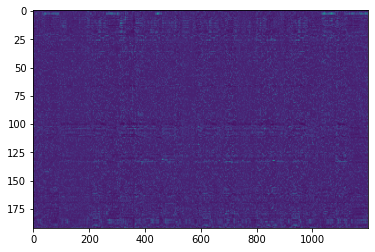

In [278]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(inputs_rs[0].T, aspect='auto')

In [187]:
import torch
from tfrecord.torch.dataset import MultiTFRecordDataset

tfrecord_pattern = "/bat_{}.tfrecord"
index_pattern = "/bat_index"
splits = {
    "": 0.8,
    "": 0.2,
}
# description = {"image": "byte", "label": "int"}
dataset = MultiTFRecordDataset(tfrecord_pattern,
                               index_pattern,
                               splits,
#                                description
                              )
loader = torch.utils.data.DataLoader(dataset, batch_size=32)

data = next(iter(loader))
print(data)

FileNotFoundError: [Errno 2] No such file or directory: '/bat_.tfrecord'